In [17]:
from __future__ import print_function, division
import os
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from mypath import Path
from torchvision import transforms
from dataloaders import custom_transforms as tr
import pandas as pd

class LiverSegmentation(Dataset):
    """
    LITS dataset
    """
    NUM_CLASSES = 2

    def __init__(self,
                 args,
                 base_dir=Path.db_root_dir('lits_liver'),
                 split='train',
                 ):
        """
        :param base_dir: path to lits dataset directory
        :param split: train/val
        :param transform: transform to apply
        """
        super().__init__()
        self._base_dir = base_dir
        self.root = os.path.join(self._base_dir,'dataset_6')
        self.df = pd.read_csv(os.path.join(self._base_dir,"lits_df.csv"))
        self.train_df = self.df[self.df['study_number']<111]
        self.test_df = self.df[self.df['study_number']>=111]
        
        if isinstance(split, str):
            self.split = [split]
        else:
            split.sort()
            self.split = split

        self.args = args

    def __len__(self):
        for split in self.split:
            if split == "train":
                return len(self.train_df)
            elif split == 'val':
                return len(self.test_df)
                
    def __getitem__(self, index):

        for split in self.split:
            if split == "train":
                imgpath = os.path.join(self.root, os.path.basename(self.train_df.iloc[index]['filepath']))
                _img = Image.open(imgpath).convert('RGB')
                maskpath = os.path.join(self.root, os.path.basename(self.train_df.iloc[index]['liver_maskpath']))
                _target = Image.open(maskpath).convert('L')
                sample = {'image': _img, 'label': _target}
                return self.transform_tr(sample)
            
            elif split == 'val':
                imgpath = os.path.join(self.root, os.path.basename(self.train_df.iloc[index]['filepath']))
                _img = Image.open(imgpath).convert('RGB')
                maskpath = os.path.join(self.root, os.path.basename(self.train_df.iloc[index]['liver_maskpath']))
                _target = Image.open(maskpath).convert('L')
                sample = {'image': _img, 'label': _target}
                return self.transform_val(sample)


    def transform_tr(self, sample):
        composed_transforms = transforms.Compose([
            tr.RandomRotate(30),
            tr.RandomHorizontalFlip(),
            # tr.RandomScaleCrop(base_size=self.args.base_size, crop_size=self.args.crop_size),
            tr.RandomGaussianBlur(),
            tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            tr.ToTensor()])

        return composed_transforms(sample)

    def transform_val(self, sample):

        composed_transforms = transforms.Compose([
            # tr.FixScaleCrop(crop_size=self.args.crop_size),
            tr.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            tr.ToTensor()])

        return composed_transforms(sample)

    def __str__(self):
        return 'LITS_liver(split=' + str(self.split) + ')'



num train img:  46404 num test img:  12234


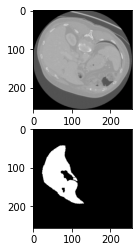

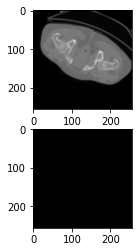

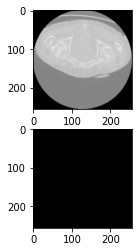

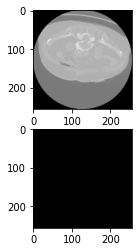

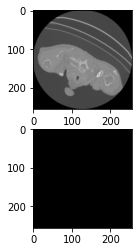

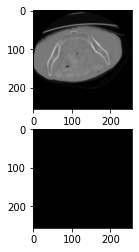

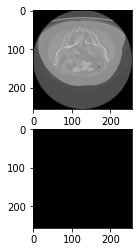

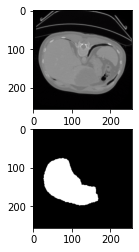

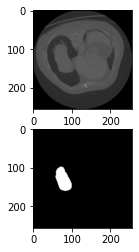

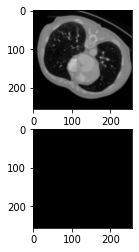

In [21]:
from dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('-f')
args = parser.parse_args()
# args.base_size = 513
# args.crop_size = 513

liver_train = LiverSegmentation(args, split='train')
liver_test = LiverSegmentation(args, split='val')

print("num train img: ", len(liver_train), "num test img: ", len(liver_test))

dataloader = DataLoader(liver_train, batch_size=5, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img = sample['image'].numpy()
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        tmp[tmp != 0] = 255
        # segmap = decode_segmap(tmp, dataset='pascal')
        img_tmp = np.transpose(img[jj], axes=[1, 2, 0])
        img_tmp *= (0.229, 0.224, 0.225)
        img_tmp += (0.485, 0.456, 0.406)
        img_tmp *= 255.0
        img_tmp = img_tmp.astype(np.uint8)
        plt.figure()
        plt.title('display')
        plt.subplot(211)
        plt.imshow(img_tmp)
        plt.subplot(212)
        plt.imshow(tmp)

    if ii == 1:
        break

plt.show(block=True) #256x256

array([0], dtype=uint8)